In [ ]:
# Imports

# Data manipulation and analysis
import pandas as pd
import numpy as np

# LightGBM for model training
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation

# Model evaluation and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    f1_score, recall_score, roc_auc_score, roc_curve
)

# Resampling techniques for imbalanced data
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing techniques
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.feature_selection import VarianceThreshold

# Time tracking
import time

# Pour sauvegarder le modèle
import joblib



In [ ]:
# Accès à Google Drive (pour Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Chargement des fichiers CSV depuis Google Drive
folder_path = '/content/drive/MyDrive/data/'
files = [
    'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
    'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    'Friday-WorkingHours-Morning.pcap_ISCX.csv',
    'Monday-WorkingHours.pcap_ISCX.csv',
    'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    'Tuesday-WorkingHours.pcap_ISCX.csv',
    'Wednesday-workingHours.pcap_ISCX.csv'
]


In [ ]:
# Fusion des datasets
dfs = [pd.read_csv(folder_path + file) for file in files]
df = pd.concat(dfs, ignore_index=True)
print("Shape:", df.shape)


Shape: (2830743, 79)


In [ ]:
#  Nettoyage : suppression des doublons
df.drop_duplicates(inplace=True)
# Remplacement des valeurs infinies par NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
# Remplir les valeurs manquantes
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
for col in non_numeric_columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# Suppression finale des lignes encore incomplètes
df.dropna(inplace=True)

In [ ]:
# Supprimer les colonnes inutiles
columns_to_drop = [
                    ' Destination Port',' Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
                   ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk',
                   ' Bwd Avg Packets/Bulk', ' Subflow Fwd Bytes', ' Subflow Bwd Packets',
                   ' Subflow Bwd Bytes', ' Idle Std', ' Idle Max', ' Idle Min']
columns_to_drop_filtered = [col for col in columns_to_drop if col in df.columns]
df.drop(columns=columns_to_drop_filtered, inplace=True)

In [ ]:
# Encodage de la colonne de label
le = LabelEncoder()
df[' Label'] = le.fit_transform(df[' Label'])

In [ ]:
# Séparation des features (X) et de la cible (y)
X = df.drop(' Label', axis=1)
y = df[' Label']


In [ ]:
# Sélection des caractéristiques avec faible variance
selector = VarianceThreshold(threshold=0.01)
X = selector.fit_transform(X)

In [ ]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Appliquer le sous-échantillonnage et l'over-sampling
rus = RandomUnderSampler(sampling_strategy={0: 30000}, random_state=42)
X_under, y_under = rus.fit_resample(X_train, y_train)
sm = SMOTE(random_state=42)
X_final, y_final = sm.fit_resample(X_under, y_under)


In [ ]:
#  Initialisation du modèle LightGBM
model = LGBMClassifier(
    objective='multiclass',
    num_class=len(np.unique(y_final)),
    random_state=42,
    is_unbalanced=True  # Activer l'équilibrage automatique des classes
)


In [ ]:
# Mesure du temps d'entraînement
start_train = time.time()

model.fit(
    X_final, y_final,
    eval_set=[(X_test, y_test)],
    eval_metric='multi_logloss',
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50)
    ]
)
end_train = time.time()
training_time = end_train - start_train
print("Temps d'entraînement (s) :", training_time)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.680017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14816
[LightGBM] [Info] Number of data points in the train set: 2074185, number of used features: 59
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Info] Start training from score -2.708

In [ ]:
# Mesure du temps de prédiction
start_pred = time.time()
y_pred = model.predict(X_test)
end_pred = time.time()
prediction_time = end_pred - start_pred
print("Temps de prédiction (s) :", prediction_time)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: is_unbalanced
Temps de prédiction (s) : 36.94361424446106


In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9931552332830499


In [ ]:
# F1 Scores
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print("F1 Score (macro):", f1_macro)
print("F1 Score (weighted):", f1_weighted)

F1 Score (macro): 0.7718964470740487
F1 Score (weighted): 0.9947020278889234


In [ ]:
# Recall (sensibilité)
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
print("Recall (macro):", recall_macro)
print("Recall (weighted):", recall_weighted)


Recall (macro): 0.9380943748302358
Recall (weighted): 0.9931552332830499


In [ ]:
#  Rapport de classification complet
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))


📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    419297
           1       0.19      1.00      0.32       391
           2       1.00      1.00      1.00     25603
           3       0.96      1.00      0.98      2057
           4       0.99      1.00      1.00     34570
           5       0.84      0.99      0.91      1046
           6       0.88      1.00      0.93      1077
           7       0.99      1.00      0.99      1187
           8       0.67      1.00      0.80         2
           9       0.07      0.86      0.13         7
          10       0.99      1.00      0.99     18164
          11       0.98      0.99      0.98       644
          12       0.29      0.63      0.40       294
          13       0.67      1.00      0.80         4
          14       0.24      0.62      0.35       130

    accuracy                           0.99    504473
   macro avg       0.72      0.94      0.77    504473

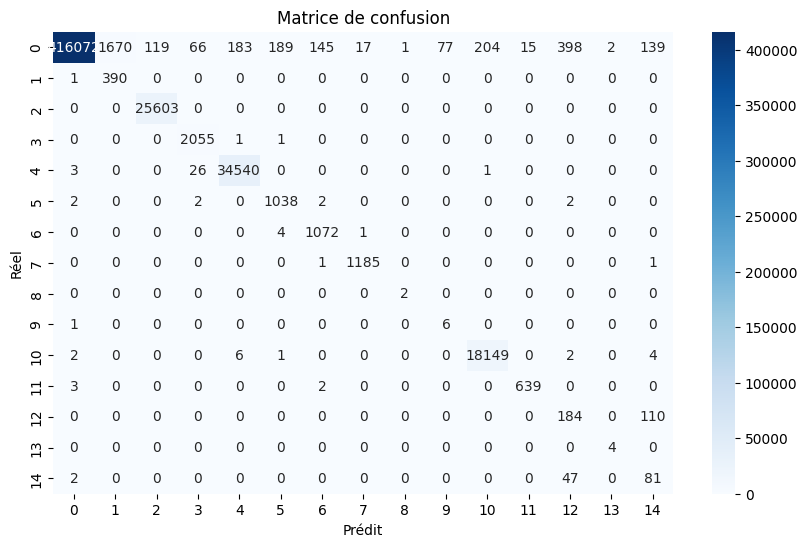

In [ ]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

In [ ]:
# AUC-ROC Score (multi-class)
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_pred_proba = model.predict_proba(X_test)
auc_score = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr')
print("AUC-ROC Score (multi-class):", auc_score)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: is_unbalanced
AUC-ROC Score (multi-class): 0.9988417165566068


In [ ]:
# Sauvegarder le modèle
joblib.dump(model, 'lightGBM_model.pkl')
print(" Modèle sauvegardé sous le nom : lightGBM_model.pkl")

 Modèle sauvegardé sous le nom : lightGBM_model.pkl
